In [ ]:
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/federated.zip

In [ ]:
import tensorflow as tf
import gc
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)


#from tensorflow.keras.mixed_precision import experimental as mixed_precision
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)
#print('Compute dtype: %s' % policy.compute_dtype)
#print('Variable dtype: %s' % policy.variable_dtype)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm

DATADIR = "/content/trainingSet"

CATEGORIES = ["lung_aca", "lung_n", "lung_scc"]

training_data = []

IMG_SIZE = 75

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                print(e)
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

print(len(training_data))


100%|██████████| 2002/2002 [00:15<00:00, 132.31it/s]

6006


In [ ]:
!unzip /content/drive/MyDrive/testSet_WithCatagory.zip

In [ ]:
DATADIR = "/content/testSet_WithCatagory"

CATEGORIES = ["lung_aca", "lung_n", "lung_scc"]

testing_data = []

IMG_SIZE = 75

def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                
                testing_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                print(e)
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))

create_training_data()

100%|██████████| 192/192 [00:01<00:00, 146.81it/s]


In [37]:
import random

random.shuffle(training_data)
random.shuffle(testing_data)

In [38]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
    

X_train = np.array(X)
X_train = X_train
y_train = np.array(y)


X_t = []
y_t = []

for features,label in testing_data:
    X_t.append(features)
    y_t.append(label)

X_test = np.array(X_t)
X_test = X_test
y_test = np.array(y_t)

In [39]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [40]:
len(X_test)

592

In [41]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [42]:
def create_clients(image_list, label_list, num_clients=10, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]
    
    data = list(zip(image_list, label_list))

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 

In [43]:
clients = create_clients(X_train, y_train, num_clients=10, initial='client')

In [44]:
def batch_data(data_shard, bs=64):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

In [45]:
#process and batch the training data for each client
clients_batched = dict()
co = 0
for (client_name, data) in clients.items():
    co+=1
    clients_batched[client_name] = batch_data(data)
    
   
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [ ]:
test_batched

<BatchDataset element_spec=(TensorSpec(shape=(None, 75, 75, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [ ]:
clients_batched

{'client_1': <BatchDataset element_spec=(TensorSpec(shape=(None, 75, 75, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>,
 'client_2': <BatchDataset element_spec=(TensorSpec(shape=(None, 75, 75, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>,
 'client_3': <BatchDataset element_spec=(TensorSpec(shape=(None, 75, 75, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>,
 'client_4': <BatchDataset element_spec=(TensorSpec(shape=(None, 75, 75, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>,
 'client_5': <BatchDataset element_spec=(TensorSpec(shape=(None, 75, 75, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>,
 'client_6': <BatchDataset element_spec=(TensorSpec(shape=(None, 75, 75, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>,
 'client_7

In [ ]:
del(X_train)
del(y_train)
del(training_data)

In [46]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow import keras
from tensorflow.keras import layers


class SimpleModel:
    def build(self):
        model = VGG19(include_top=False,input_shape=(75, 75, 3), weights='imagenet')
        transfer_layer = model.get_layer('block5_pool')
        conv_model = Model(inputs=model.input, outputs=transfer_layer.output)
        # Start a new Keras Sequential model.
        new_model = Sequential()

        # Add the convolutional part of the VGG16 model from above.
        new_model.add(conv_model)

        # Flatten the output of the VGG16 model because it is from a
        # convolutional layer.
        new_model.add(Flatten())

        # Add a dense (aka. fully-connected) layer.
        # This is for combining features that the VGG16 model has
        # recognized in the image.

        new_model.add(Dense(512, activation='relu'))


        # Add the final layer for the actual classification.
        new_model.add(Dense(3, activation='softmax'))
        
        model1 = InceptionV3(include_top=False,input_shape=(75, 75, 3), weights='imagenet')
        transfer_layer1 = model1.get_layer('mixed10')
        conv_model1 = Model(inputs=model1.input, outputs=transfer_layer1.output)
        new_model1 = Sequential()

        new_model1.add(conv_model1)

        new_model1.add(Flatten())

        #new_model1.add(Dropout(0.5))

        new_model1.add(Dense(512, activation='relu'))

        # Add the final layer for the actual classification.
        new_model1.add(Dense(3, activation='softmax'))
        
        
        
        
        model1 = DenseNet121(include_top=False,input_shape=(75, 75, 3), weights='imagenet')
        transfer_layer1 = model1.get_layer('bn')
        conv_model2 = Model(inputs=model1.input, outputs=transfer_layer1.output)
        new_model2 = Sequential()

        new_model2.add(conv_model1)

        new_model2.add(Flatten())

        #new_model1.add(Dropout(0.5))

        new_model2.add(Dense(512, activation='relu'))

        # Add the final layer for the actual classification.
        new_model2.add(Dense(3, activation='softmax'))
        
        inputs = keras.Input(shape=(75,75,3))
        
        outputs = layers.average([new_model(inputs),new_model1(inputs),new_model2(inputs)])
        ensemble_model = keras.Model(inputs=inputs, outputs=outputs)
        
        
        return ensemble_model
        

In [47]:
from tensorflow.keras.optimizers import SGD
optimizer = Adam(lr=.00001)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']

In [48]:
def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    print(global_count)
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss

In [49]:
smlp_global = SimpleModel()
global_model = smlp_global.build()
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score

local_model = smlp_global.build()
local_model.compile(optimizer= 'adam', loss=loss, metrics=metrics)

29084464/29084464 [==============================] - 1s 0us/step


In [50]:
import multiprocessing
comms_round = 20
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    
    
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    client_names= list(clients_batched.keys())
    
    #random.shuffle(client_names)
    
    #loop through each client and create new local model
    count = 0
    for client in client_names:
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=1)
        test_model(X_test, y_test, local_model, comm_round)
        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        
        #K.clear_session()
        #gc.collect()
        #del local_model
    
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)

19/19 [==============================] - 6s 114ms/step
comm_round: 0 | global_acc: 32.432% | global_loss: 1.0986121892929077
6400
19/19 [==============================] - 1s 51ms/step
comm_round: 0 | global_acc: 33.953% | global_loss: 1.1179436445236206
6400
19/19 [==============================] - 1s 53ms/step
comm_round: 0 | global_acc: 35.135% | global_loss: 1.1255894899368286
6400
19/19 [==============================] - 1s 50ms/step
comm_round: 0 | global_acc: 33.108% | global_loss: 1.098611831665039
6400
19/19 [==============================] - 1s 50ms/step
comm_round: 0 | global_acc: 35.135% | global_loss: 1.1263028383255005
6400
19/19 [==============================] - 1s 51ms/step
comm_round: 0 | global_acc: 35.135% | global_loss: 1.1991537809371948
6400
19/19 [==============================] - 1s 51ms/step
comm_round: 0 | global_acc: 35.135% | global_loss: 1.1263020038604736
6400
19/19 [==============================] - 1s 50ms/step
comm_round: 0 | global_acc: 35.135% | globa


KeyboardInterrupt



In [ ]:
# Plot the confusion matrix. Set Normalize = True/False

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')




predict_x=global_model.predict(X_test) 
y_pred=np.argmax(predict_x,axis=1)

y_testreport=np.argmax(y_test,axis=1)


from sklearn.metrics import classification_report, confusion_matrix

#Print Classification Report

print('Classification Report')
print(classification_report(y_testreport, y_pred, target_names=["lung_aca", "lung_n", "lung_scc"]))

19/19 [==============================] - 1s 55ms/step
Classification Report
              precision    recall  f1-score   support

    lung_aca       0.87      1.00      0.93       192
      lung_n       1.00      1.00      1.00       208
    lung_scc       1.00      0.85      0.92       192

    accuracy                           0.95       592
   macro avg       0.96      0.95      0.95       592
weighted avg       0.96      0.95      0.95       592



Confusion Matrix
Confusion matrix, without normalization


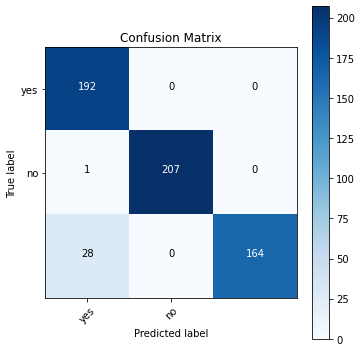

In [ ]:
import itertools
print('Confusion Matrix')
cm = confusion_matrix(y_testreport, y_pred)
plot_confusion_matrix(cm, ["yes","no"], title='Confusion Matrix')